In [428]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [429]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Arial']
matplotlib.rcParams['font.sans-serif'] = ['System Font', 'Verdana', 'Arial']
matplotlib.rcParams['figure.figsize'] = (7, 3)   # Change the size of plots
matplotlib.rcParams['figure.dpi'] = 108

In [550]:
import os
import numpy as np
import numpy.matlib

In [519]:
# Time interval between readings
d = 1.0 / 5000.0

# Time-series data usually come in chunks
chunk_size = 8

# A scaling constant of the clean reference
tics_per_second = 1000000

# Have the time-series to be at least X seconds
K = int(8.0 / d / chunk_size / 2) * chunk_size * 2

# Emulate staggered PRT: 2, 3, 2, 3, ...
y = np.cumsum(np.kron(np.ones(int(K / 2), ), [2, 3])) * (0.5 * d)

# Clean reference of tic count
u_orig = 19760520
u = (y + u_orig) * tics_per_second

# Time in double with an arbitrary offset
y_orig = 7000.0
y = y + y_orig

# Add noise to x, on the orders of milliseconds
L = round(K / chunk_size, )
jitter = np.kron(0.5e-3 * (np.random.random(L, ) - 0.5), np.ones(chunk_size, ))
burst = np.kron(np.ones(L, ), np.linspace(0, 0.05e-3, chunk_size) - 0.025e-3)

x_orig = y_orig
x = y + jitter + burst

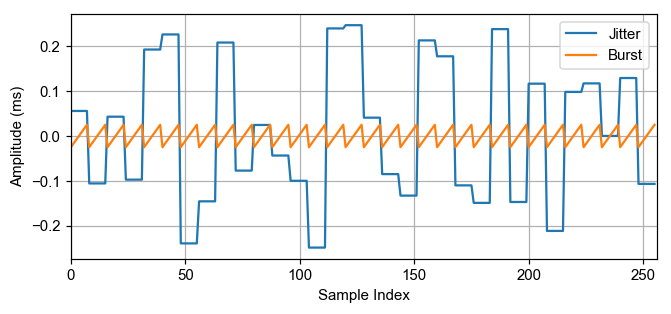

In [571]:
L = 256
matplotlib.pyplot.plot(1.0e3 * jitter[:L], label='Jitter')
matplotlib.pyplot.plot(1.0e3 * burst[:L], label='Burst')
matplotlib.pyplot.xlim([0, L])
matplotlib.pyplot.legend()
matplotlib.pyplot.grid()
matplotlib.pyplot.xlabel('Sample Index')
matplotlib.pyplot.ylabel('Amplitude (ms)')

In [572]:
def sim(x, M, N):
    h_x0 = np.ones(x.shape) * np.nan
    h_u0 = np.ones(x.shape) * np.nan
    h_dx = np.ones(x.shape) * np.nan
    t = np.ones(x.shape) * np.nan
    b = 1.0 / M
    a = 1.0 - b

    for i in range(2, len(x)):
        if i < N:
            if i % 2 == 0:
                x0 = np.mean(x[:i])
                u0 = np.mean(u[:i])
            dx = (x[i] - x[0]) / (u[i] - u[0])
        else:
            if i % 2 == 0:
                x0 = np.mean(x[i - N : i])
                u0 = np.mean(u[i - N : i])
            dx = a * dx + b * (x[i] - x[i - N]) / (u[i] - u[i - N])

        t[i] = x0 + dx * (u[i] - u0)
        # Keep a history
        h_x0[i] = x0
        h_u0[i] = u0
        h_dx[i] = dx

    # For plotting, set the beginning t values to be nice
    t[1] = t[2] - d
    t[0] = t[1] - d
    
    return t, h_x0, h_u0, h_dx

In [573]:
def showChart(t, h_x0, h_u0, h_dx):
    fig = matplotlib.pyplot.figure(figsize=(11, 6))

    xx = y - y[0]

    ax1 = fig.add_subplot(221)
    h1 = ax1.plot(xx, 1.0e3 * (t - y), '-m')
    ax1.grid()
    ax1.text(y[-1] - y[0], 1.3, 'M = {}, N = {}'.format(M, N), ha='right')
    matplotlib.pyplot.ylabel('Time Error (ms)')
    matplotlib.pyplot.ylim([-3.0, 3.0])
#     ax1b = ax1.twinx()
#     h2 = ax1b.plot(xx, (u - h_u0) * 1.0e-6 / M, 'g')
#     h2 = ax1b.plot(xx[0::2], (u - h_u0)[0::2] * 1.0e-6 * d * M, 'g')
#     matplotlib.pyplot.ylim([0, 1.0e9])
#     ax1b.legend(h1 + h2, ['Time', 'Reference'], loc=4)
#     matplotlib.pyplot.title('Accuracy of Time & Reference')

    ax2 = fig.add_subplot(222)
    ax2.plot(xx, h_dx * tics_per_second, label='Estimate')
    ax2.plot(xx[[0, -1]], np.array([1.0, 1.0]), '--', label='True dx / du')
    ax2.grid()
    ax2.legend()
    matplotlib.pyplot.ylim([0.999, 1.001])
    matplotlib.pyplot.title('Time History of dx / du')

    ax3 = fig.add_subplot(223)
    h31 = ax3.plot(xx, (h_u0 - u_orig) / tics_per_second)
    h32 = ax3.plot(xx[[0, -1]], (u[[0, -1]] - u_orig) / tics_per_second, '--')
    ax3.grid()
    ax3.legend(h31 + h32, ['Estimate', 'True u0'])

    ax4 = fig.add_subplot(224)
    h41 = ax4.plot(xx, h_x0 - x_orig)
    h42 = ax4.plot(xx[[0, -1]], xx[[0, -1]], '--')
    ax4.grid()
    ax4.legend(h41 + h42, ['Estimate', 'True x0'])

    return fig

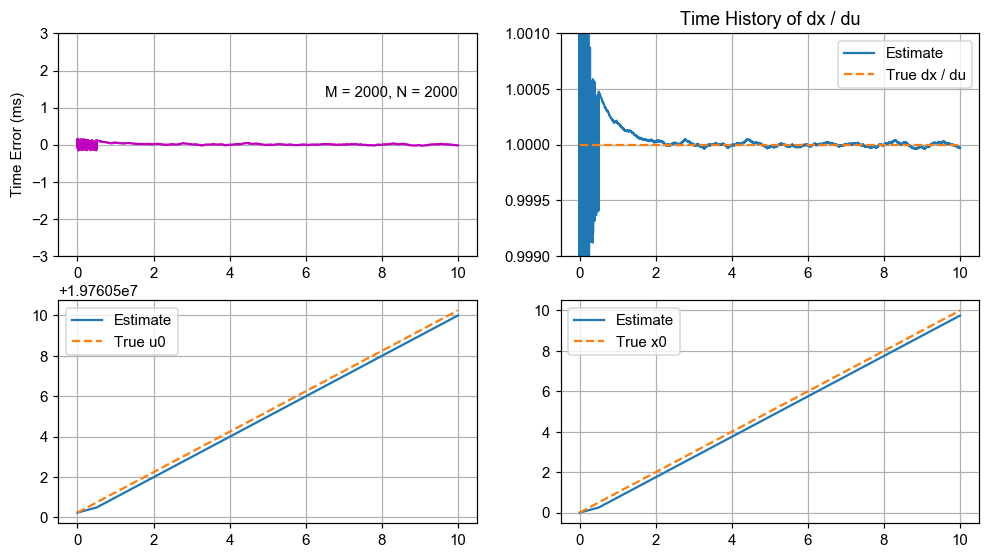

In [574]:
# Stride size of the running window
M = 2000
N = 2000

# for M in [1000, 2000, 5000, 10000]:
t, h_x0, h_u0, h_dx = sim(x, M, N)
fig = showChart(t, h_x0, h_u0, h_dx)
fig.savefig(os.environ['HOME'] + '/Desktop/m{0:02.0f}-n{1:02.0f}.png'.format(M / 1000, N / 1000))

Original jitter = 0.0708992231722  ms
Smoothed jitter = 0.000173810274872  ms


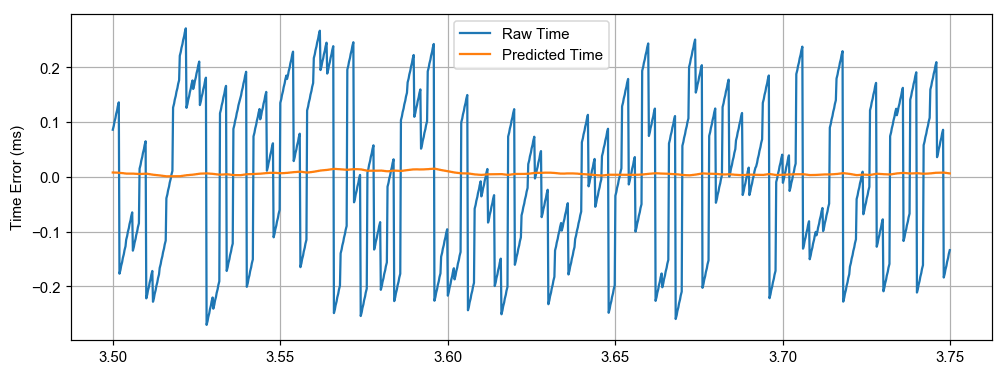

In [575]:
O = int(3.5 / ((2 + 3) * 0.5 * d) * 2)
L = 1000

xx = y[O:O+L] - y[0]
ts1 = 1.0e3 * (x[O:O+L] - y[O:O+L])
ts2 = 1.0e3 * (t[O:O+L] - y[O:O+L])

print('Original jitter =', np.std(np.diff(ts1)), ' ms')
print('Smoothed jitter =', np.std(np.diff(ts2)), ' ms')

fig = matplotlib.pyplot.figure(figsize=(11, 4))
ax = fig.add_subplot(111)
matplotlib.pyplot.plot(xx, ts1, '-', label='Raw Time')
matplotlib.pyplot.plot(xx, ts2, '-', label='Predicted Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.legend()
matplotlib.pyplot.ylabel('Time Error (ms)')

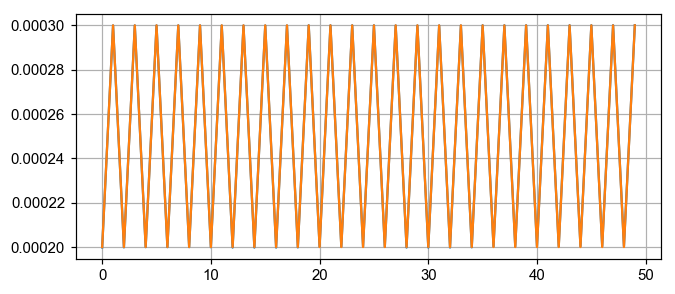

In [568]:
matplotlib.pyplot.plot(np.diff(t)[-50:])
matplotlib.pyplot.plot(np.diff(y)[-50:])
matplotlib.pyplot.grid()